# Flat Trigger Tower Pt Distribution

In this notebook, we will be applying simple eFEX cuts to full data, then with the remaining data, removing electron or jet events accordingly to create a data with the same trigger tower pt distribution for both electrons and jets.

In [2]:
# Importing required packages
import numpy as np
import matplotlib as mpl  
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [3]:
# Setting up parameters for plots
mpl.rcParams['figure.figsize'] = [14.0, 10.0]
mpl.rcParams['font.size']=15
# plt.style.use('seaborn-darkgrid')

In [4]:
# atlas_style = AtlasStyle(
#     atlas='Simulation Internal',
#     offset=7,
#     indent=7,
#     font_size=33,
#     label_font_size=23,
#     sub_font_size=30,
#     enlarge=1
# )

## Importing data

In [5]:
ele_data = np.loadtxt('elefull(nolabels).txt', delimiter = '	')

jet_data1 = np.loadtxt('jetfull(nolabels).txt', delimiter = '	')
jet_data2 = np.loadtxt('jetfull_jz1(nolabels).txt', delimiter = '	')
jet_data3 = np.loadtxt('jetfull_jz2(nolabels).txt', delimiter = '	')
jet_data4 = np.loadtxt('jetfull_jz3(nolabels).txt', delimiter = '	')

jet_data = np.concatenate((jet_data1, jet_data2, jet_data3, jet_data4), axis =0)

print("Initial number of ele data", len(ele_data))
print("Initial number of jet data", len(jet_data))
print("Shape of data", np.shape(ele_data[0]))

Initial number of ele data 27524
Initial number of jet data 45749
Shape of data (63,)


## Applying simple eFEX cuts

Similarly from "*Simple_Parameter_Cut.ipynb*", the cut values are found and applied.

In [6]:
cut_est = [np.linspace(0.8, 0.9, 1000),
           np.linspace(10000, 15000, 1000),
           np.linspace(0, 0.07, 1000),
           np.linspace(0, 0.04, 1000),
          ]
sig = [0.98,0.99,0.99,0.99]

para_name = ["Reta","ws2","rhad","f3"]

para_index = [6,8,10,9]

para_type = [1, 1, 2, 2]

In [7]:
def cut_value(cut_est, sig, para_name, para_index, para_type):
    '''
    Function to find cut value given a specific signal efficiency using a for loop
    
    Input:
    cut_est = estimated range of cut value
    sig = required signal efficiency
    para_name = parameter cut name
    para_index = parameter cut index in data
    para_type = two types of cut
    
    Output:
    cut = final cut value
    '''
    # Initialise cut value
    cut = 0
    
    # Loop to find cut value in estimated range that gives required signal efficiency
    for i in cut_est:
        ele_store = []                               # temporary storage for electron that passes cut
        
        # Two types of cut (above/below cut value)
        if para_type == 1:
            for j in range(len(ele_data)):
                if ele_data[j][para_index] >= i:
                    ele_store.append(ele_data[j])
            est_sig = len(ele_store)/len(ele_data)   # calculating signal efficiency using estimated cut
            if est_sig <= sig:                       # stop loop when required signal efficiency is achieved
                cut = i
                break
                
        if para_type == 2:
            for j in range(len(ele_data)):
                if ele_data[j][para_index] <= i:
                    ele_store.append(ele_data[j])
            est_sig = len(ele_store)/len(ele_data)  # calculating signal efficiency using estimated cut
            if est_sig >= sig:                      # stop loop when required signal efficiency is achieved
                cut = i
                break
                
    print(para_name, "cut value for {0:.4f} signal efficiency = {1:.5f}".format(est_sig, cut)) # print cut value and signal efficiency achieved
    return cut

In [8]:
# Using function to find cut value for each parameter
cut = []
for i, j, k, l, m in zip(cut_est, sig, para_name, para_index, para_type):
    cut.append(cut_value(i, j, k, l,m))
    

# Applying cut to ele data    
ele_data_cut = []
for i in range (len(ele_data)):
    if ele_data[i][6]>=cut[0] and ele_data[i][8]>=cut[1] and ele_data[i][10]<=cut[2] and ele_data[i][9]<=cut[3]:
        ele_data_cut.append(ele_data[i])
        
# Applying cut to jet data
jet_data_cut = []
for i in range (len(jet_data)):
    if jet_data[i][6]>=cut[0] and jet_data[i][8]>=cut[1] and jet_data[i][10]<=cut[2] and jet_data[i][9]<=cut[3]:
        jet_data_cut.append(jet_data[i])

f_sig = len(ele_data_cut)/len(ele_data)                             # calculating final signal achieved
print("Final signal efficiency achieved = {0:.4f}".format(f_sig))   # print final signal efficiency

Reta cut value for 0.9799 signal efficiency = 0.85215
ws2 cut value for 0.9897 signal efficiency = 14604.60460
rhad cut value for 0.9900 signal efficiency = 0.05543
f3 cut value for 0.9900 signal efficiency = 0.02539
Final signal efficiency achieved = 0.9541


## Creating Flat Trigger Tower Pt Distribution

1. The original trigger tower distribution for electron and jet is plot with 200 bins at the same bin values.
2. For each bin range, only keep a events depending on whether electrons or jets have a lower number of events.
<br>
For instance, let's take that at trigger tower pt range 20-21GeV, there are 1000 electron events and 200 jet events, we will only be keeping 200 electron events and all of jet events

In [9]:
ele_tt = []                                     # array for electron trigger tower pt
for i in range (len(ele_data_cut)):
    ele_tt.append(ele_data_cut[i][3])
    

jet_tt = []                                     # array for jet trigger tower pt
for i in range (len(jet_data_cut)):
    jet_tt.append(jet_data_cut[i][3])
    
    
sample_tt = np.append(ele_tt, jet_tt, axis=0)

(0.0, 2000.0)

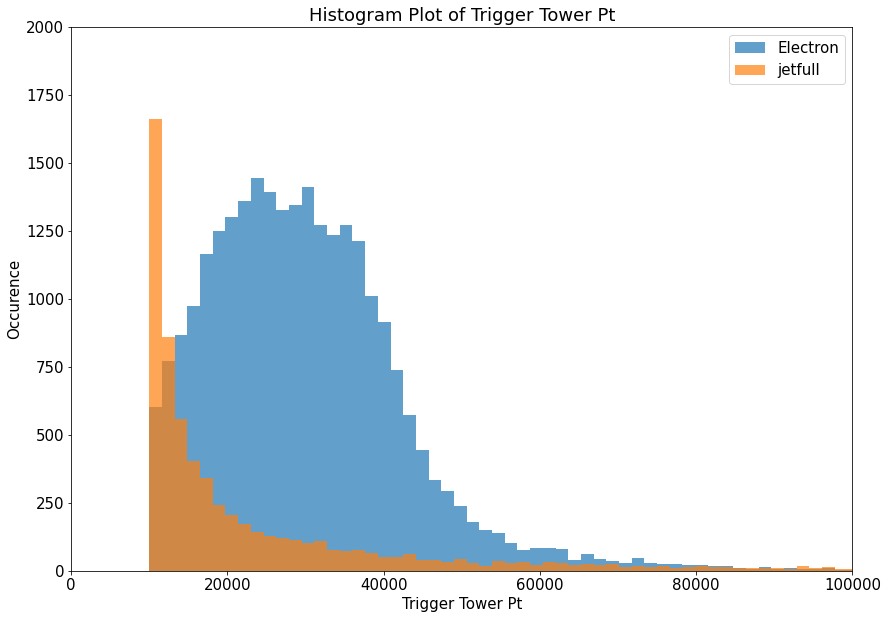

In [10]:
ttbins = np.linspace(np.min(sample_tt), np.max(sample_tt), 201)                             # bin array for histogram

# Plot
plt.figure()
n_ele, bins_ele, patches_ele = plt.hist(ele_tt, bins=ttbins, label = 'Electron', alpha=0.7) # electron tt pt plot
n_jet, bins_jet, patches_jet = plt.hist(jet_tt, bins=ttbins, label = 'jetfull', alpha=0.7)  # jet tt pt plot
plt.ylabel("Occurence")                                                                     # label y-axes
plt.xlabel("Trigger Tower Pt")                                                              # label x-axes
plt.title("Histogram Plot of Trigger Tower Pt")                                             # plot title
plt.legend(loc='best')                                                                      # show legend      
plt.xlim(0, 100000)                                                                         # x-axes limit
plt.ylim(0, 2000)                                                                           # y-axes limit

## Removing data for every bin

In [11]:
ele_flat = []                           # array for remaining electrons
jet_flat = []                           # array for remaining jets

for i in range (len(n_ele)):
    n = 0
    
    # 1st scenario for no. of jet events > no. of ele events
    if n_jet[i] > n_ele[i]:
        
        # Keep all electron events
        for j in range (len(ele_data_cut)):
            if ele_data_cut[j][3] >= bins_ele[i] and ele_data_cut[j][3] < bins_ele[i+1]:
                ele_flat.append(ele_data_cut[j])
                
        # Only keep jet events according to no. of ele events
        for k in range (len(jet_data_cut)):
            if jet_data_cut[k][3] >= bins_ele[i] and jet_data_cut[k][3] < bins_ele[i+1] and n <= n_ele[i]:
                jet_flat.append(jet_data_cut[k])
                n = n + 1
                
    # 2nd scenario for no. of jet events < no. of ele events
    elif n_jet[i] < n_ele[i]:
        
        # Keep all jet events
        for l in range (len(jet_data_cut)):
                if jet_data_cut[l][3] >= bins_ele[i] and jet_data_cut[l][3] < bins_ele[i+1]:
                    jet_flat.append(jet_data_cut[l])
        
        # Only keep ele events according to no. of jet events
        for m in range (len(ele_data_cut)):
            if ele_data_cut[m][3] >= bins_ele[i] and ele_data_cut[m][3] < bins_ele[i+1] and n <= n_jet[i]:
                ele_flat.append(ele_data_cut[m])
                n = n + 1

## Histogram plot to verify flat distribution is created

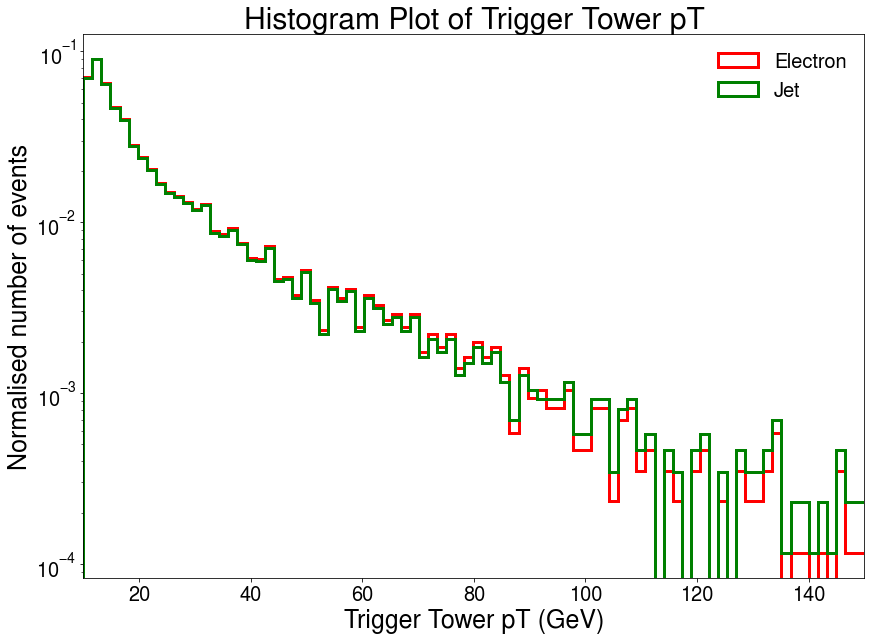

In [15]:
ele_flat_tt = []                          # array of trigger tower pt for remaning ele data
for i in range (len(ele_flat)):
    ele_flat_tt.append(ele_flat[i][3])
    

jet_flat_tt = []                          # array of trigger tower pt for reamining jet data
for i in range (len(jet_flat)):
    jet_flat_tt.append(jet_flat[i][3])
    
    
# Plot of remaining ele compare to original jets
# plt.figure()
# n_ele, bins_ele, patches_ele = plt.hist(ele_flat_tt, bins=ttbins, label = 'Flat Electron', alpha=0.6) # remaining ele plot
# n_jet, bins_jet, patches_jet = plt.hist(jet_tt, bins=ttbins, label = 'Original Jet', alpha=0.6)       # original jet plot
# plt.ylabel("Occurence")                                                                               # label y-axes
# plt.xlabel("Trigger Tower Pt")                                                                        # label x-axes
# plt.title("Histogram Plot of Trigger Tower Pt")                                                       # plot title
# plt.legend(loc='best')                                                                                # show legend
# plt.xlim(0, 100000)                                                                                   # x-axes limit
# plt.ylim(0, 2000)                                                                                     # y-axes limit

# # Plot of remaining jets compare to original ele
# plt.figure()
# n_ele, bins_ele, patches_ele = plt.hist(ele_tt, bins=ttbins, label = 'Original Electron', alpha=0.6)  # original ele plot
# n_jet, bins_jet, patches_jet = plt.hist(jet_flat_tt, bins=ttbins, label = 'Flat Jet', alpha=0.6)      # remaning jet plot
# plt.ylabel("Occurence")                                                                               # label y-axes
# plt.xlabel("Trigger Tower Pt")                                                                        # label x-axes
# plt.title("Histogram Plot of Trigger Tower Pt")                                                       # plot title
# plt.legend(loc='best')                                                                                # show legend
# plt.xlim(0, 100000)                                                                                   # x-axes limit
# plt.ylim(0, 2000)                                                                                     # y-axes limit

ttbins = np.linspace(np.min(sample_tt/1000), np.max(sample_tt/1000), 201)                             # bin array for histogram

for i in range (len(ele_flat_tt)):
    ele_flat_tt[i] = ele_flat_tt[i]/1000

for i in range (len(jet_flat_tt)):
    jet_flat_tt[i] = jet_flat_tt[i]/1000
# Plot of remaining data
plt.figure()
n_ele, bins_ele, patches_ele = plt.hist(ele_flat_tt,
                                        bins=ttbins, label = 'Electron', 
                                        histtype='step', 
                                        lw=3, 
#                                         log=True,
                                        density=True,
                                        color='red'
                                       ) # remaining ele plot
n_jet, bins_jet, patches_jet = plt.hist(jet_flat_tt, 
                                        bins=ttbins, label = 'Jet',  
                                        histtype='step', 
                                        lw=3, 
#                                         log=True,
                                        density=True,
                                        color='green'
                                       )      # remaining jet plot
plt.ylabel("Normalised number of events", size=25)                                                                               # label y-axes
plt.xlabel("Trigger Tower pT (GeV)", size=25)                                                                        # label x-axes
plt.title("Histogram Plot of Trigger Tower pT", size=30)                                                       # plot title
plt.legend(loc='best', frameon=False, fontsize=20)                                                                                # show legend
plt.xlim(10, 150)    
plt.yscale('log')
plt.tick_params(axis='both', labelsize=20)
# x-axes limit
# plt.ylim(, 0.1)                                                                                     # y-axes limit
# hist_leg(ax, ncol=2, fontsize=11)
# AtlasStyle.apply

# for i in range(len(ele_flat_tt)):
#     ele_flat_tt[i] = ele_flat_tt[i]/1000
# for i in range(len(jet_flat_tt)):
#     jet_flat_tt[i] = jet_flat_tt[i]/1000


# ttbins1 = np.linspace(np.min(np.concatenate((ele_flat_tt, jet_flat_tt))), np.max(np.concatenate((ele_flat_tt, jet_flat_tt))), 201)

# plt.figure()
# n_ele, bins_ele, patches_ele = plt.hist(ele_flat_tt, bins=ttbins1, label = 'Flat Electron', 
# #                                         alpha=0.7, 
#                                         histtype='step', 
#                                         lw = 3, 
#                                         density=True
#                                        )
# n_jet, bins_jet, patches_jet = plt.hist(jet_flat_tt, bins=ttbins1, label = 'Flat Jet',
# #                                         alpha=0.7, 
#                                         histtype='step', 
#                                         lw = 3, 
#                                         density=True
#                                        )
# plt.ylabel("Normalised number of events", size=25)
# plt.xlabel("Trigger Tower Pt", size=25)
# # plt.title("Histogram Plot of Trigger Tower Pt", size=30)
# plt.legend(loc='best', frameon=False)
# plt.xlim(10, 150)
# plt.ylim(0, 1e-1)
# plt.yscale('log')
# atlas_style.apply()
# plt.tick_params(axis='both', labelsize=20)

In [13]:
print("Final number of ele data remaining", len(ele_flat))
print("Final number of jet data remaining", len(jet_flat))
from atlasify import AtlasStyle


Final number of ele data remaining 5281
Final number of jet data remaining 5314


### Saving data as .txt file

In [ ]:
# np.savetxt("cut_ele_data_flat.txt", ele_flat,  delimiter = '	')
# np.savetxt("cut_jet_data_flat.txt", jet_flat,  delimiter = '	')